

```
Write a report (in LATEX)
• Name it « Report.3.cuda.tex »
• Explain how you implement the labwork
• Try experimenting with different block size values
• Plot a graph of block size vs time
• Discuss the graph
• Push the report and your code to your forked repository
```



In [1]:
!wget -O image.jpg  https://64.media.tumblr.com/5e0c6acb25df56613907574c0cd244e4/tumblr_mhwsoaQpXT1rttifoo1_1280.jpg

--2024-10-20 04:20:40--  https://64.media.tumblr.com/5e0c6acb25df56613907574c0cd244e4/tumblr_mhwsoaQpXT1rttifoo1_1280.jpg
Resolving 64.media.tumblr.com (64.media.tumblr.com)... 192.0.77.3
Connecting to 64.media.tumblr.com (64.media.tumblr.com)|192.0.77.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443180 (433K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 432.79K  --.-KB/s    in 0.04s   

2024-10-20 04:20:40 (11.9 MB/s) - ‘image.jpg’ saved [443180/443180]



# Raw image

Image dimensions: (968, 1296)


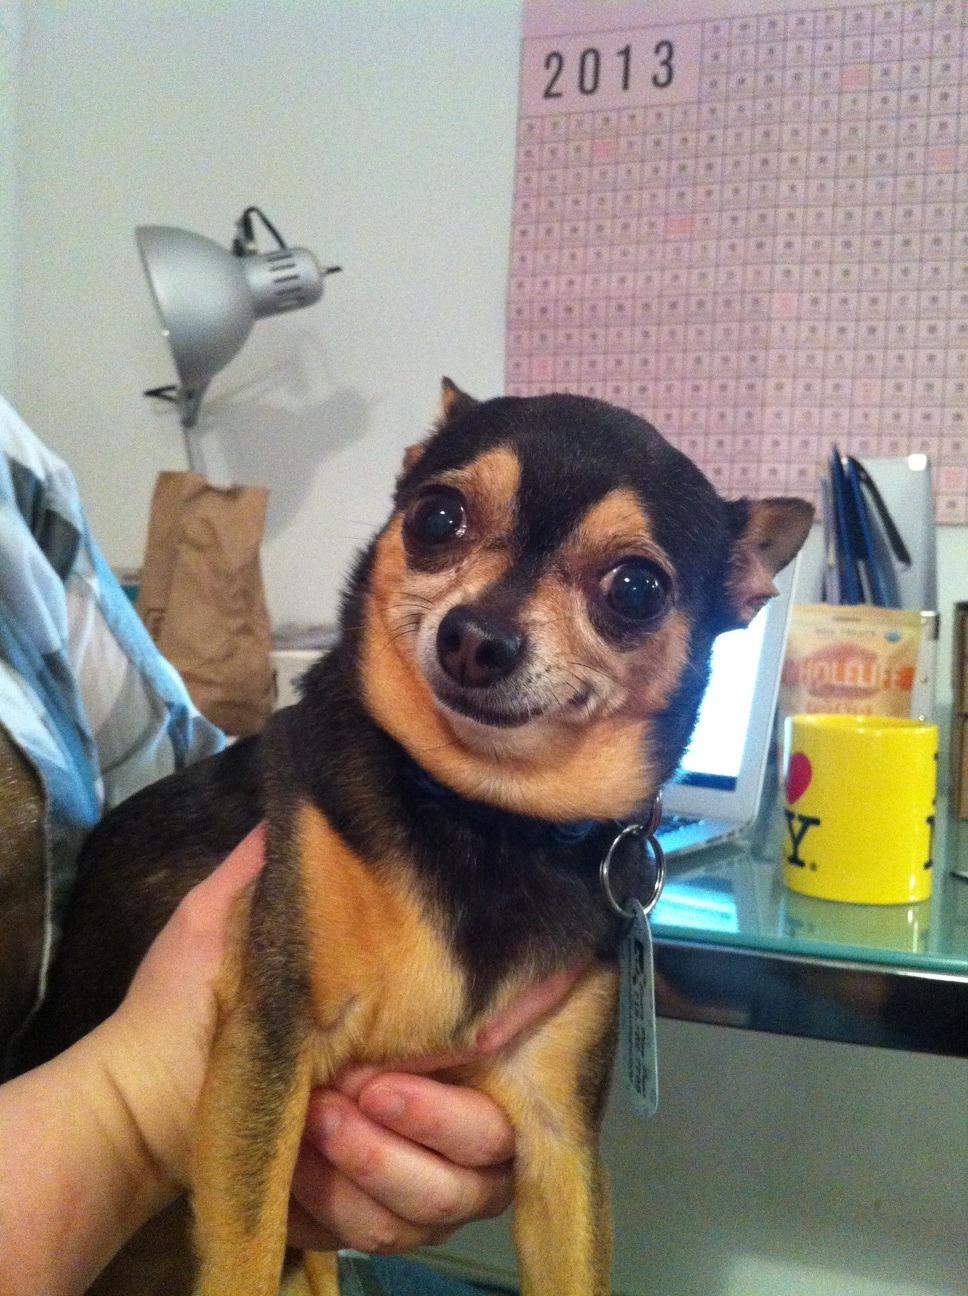

In [2]:
from PIL import Image
from IPython.display import display

img = Image.open('/content/image.jpg')

print("Image dimensions:", img.size)


display(img)

# Sequential version

Time taken: 1.5656239986419678 seconds


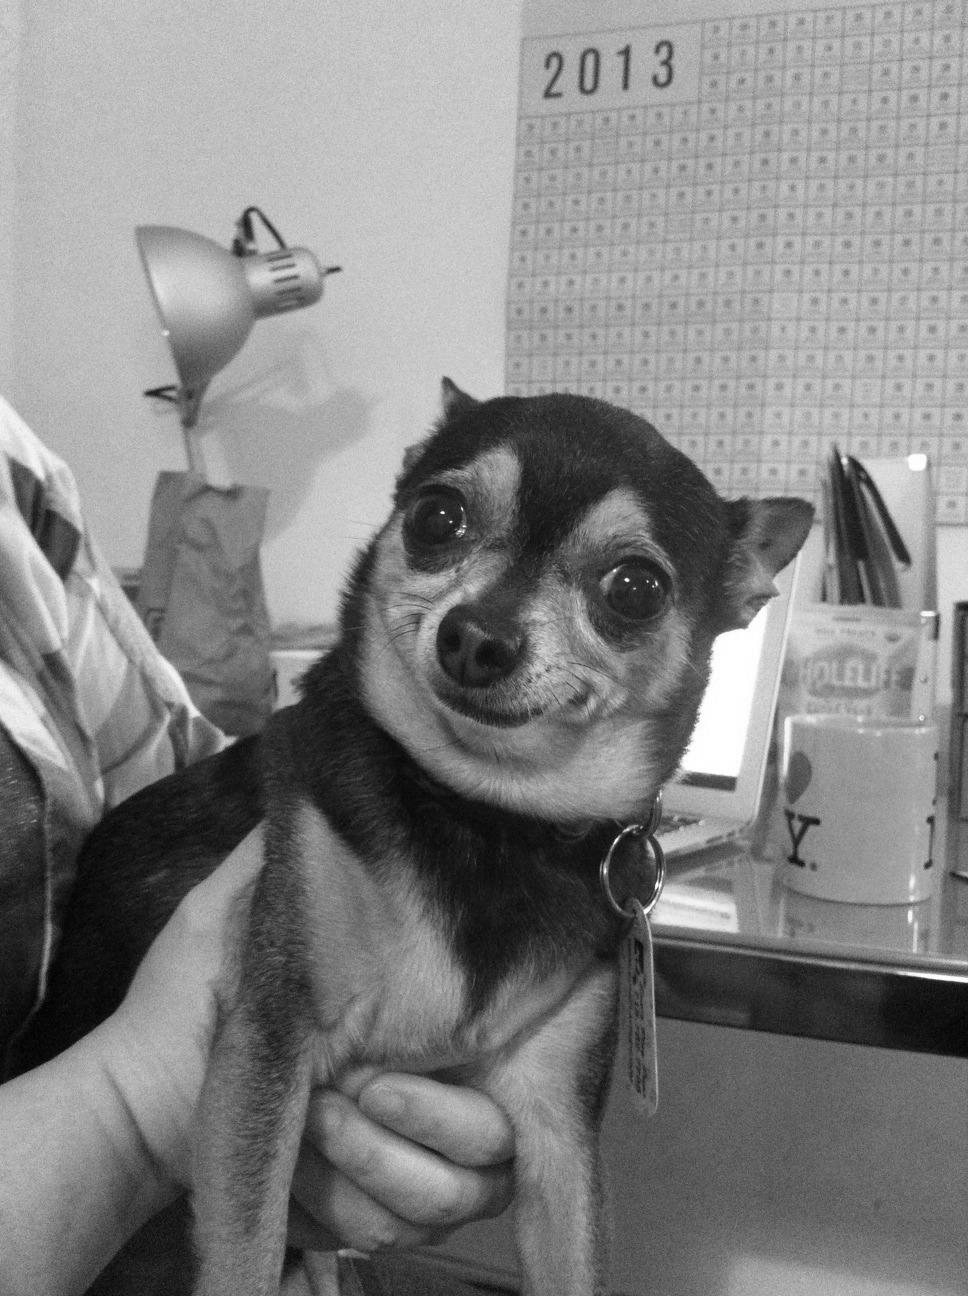

In [10]:
from PIL import Image
import time
from IPython.display import display
import numpy as np

# Start the timer
start_time = time.time()

# Load the image
img = Image.open('/content/image.jpg')

rgb_array = np.array(img)
# Create an empty array for the grayscale image
gray_array = np.zeros((rgb_array.shape[0], rgb_array.shape[1]), dtype=np.uint8)

# # Convert the image to grayscale manually using average formula
width, height = gray_array.shape[0], gray_array.shape[1]

for x in range(width):
    for y in range(height):
        r = rgb_array[x, y, 0]
        g = rgb_array[x, y, 1]
        b = rgb_array[x, y, 2]
        gray_array[x, y] = int((float(r) + float(g) + float(b)) / 3)


# End the timer
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

# Display the grayscale image using IPython
gray_img = Image.fromarray(gray_array)
display(gray_img)

# GPU

Time taken: 1.2127690315246582 seconds


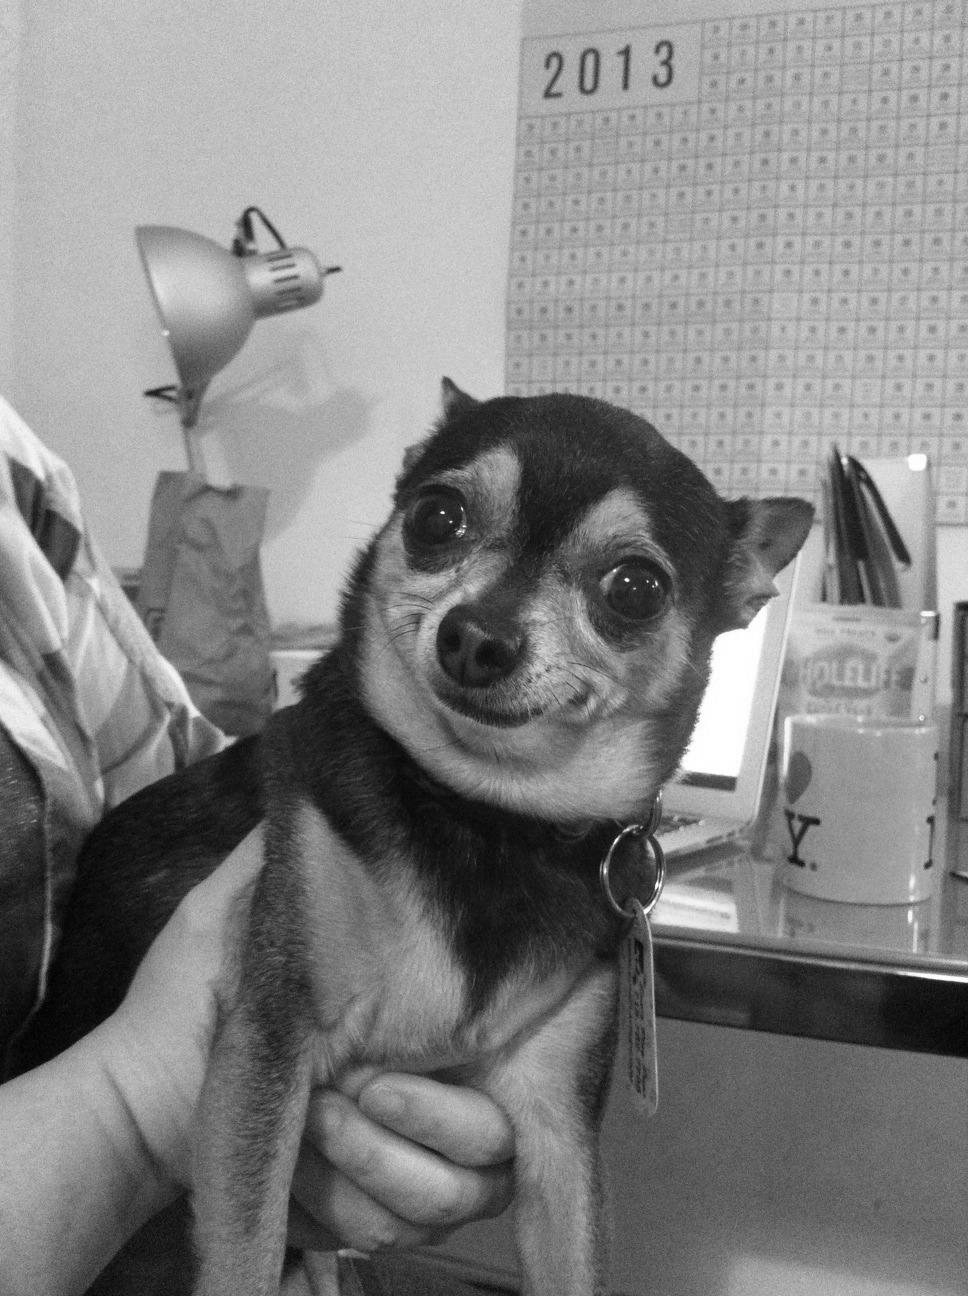

In [5]:
from PIL import Image
import time
from IPython.display import display
from numba import cuda
import numpy as np

# Function to convert the image to grayscale on the GPU
@cuda.jit
def rgb_to_gray_gpu(rgb_array, gray_array):
    idx = cuda.grid(1)  # 1D grid and block indexing
    x = idx // rgb_array.shape[1]  # Row index
    y = idx % rgb_array.shape[1]   # Column index

    if x < rgb_array.shape[0] and y < rgb_array.shape[1]:
        r = rgb_array[x, y, 0]
        g = rgb_array[x, y, 1]
        b = rgb_array[x, y, 2]
        # Average formula for grayscale
        gray_value = (r + g + b) // 3
        gray_array[x, y] = gray_value

# Start the timer
start_time = time.time()

# Load the image and convert to NumPy array
img = Image.open('/content/image.jpg')
rgb_array = np.array(img)

# Create an empty array for the grayscale image
gray_array = np.zeros((rgb_array.shape[0], rgb_array.shape[1]), dtype=np.uint8)

# Define the block and grid size for GPU execution
threads_per_block = 256  # 1D block size
blocks_per_grid = (rgb_array.size + (threads_per_block - 1)) // threads_per_block

# Copy data to the GPU
rgb_array_device = cuda.to_device(rgb_array)
gray_array_device = cuda.to_device(gray_array)

# Run the kernel on the GPU
rgb_to_gray_gpu[blocks_per_grid, threads_per_block](rgb_array_device, gray_array_device)

# Copy the result back to the host
gray_array_device.copy_to_host(gray_array)

# End the timer
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

# Convert the grayscale array back to an image
gray_img = Image.fromarray(gray_array)

# Display the grayscale image using IPython
display(gray_img)


## Python script

In [6]:
%%writefile convert_to_gray.py
import argparse
import time
from PIL import Image
from numba import cuda
import numpy as np

# Function to convert the image to grayscale on the GPU
@cuda.jit
def rgb_to_gray_gpu(rgb_array, gray_array):
    idx = cuda.grid(1)  # Use 1D indexing
    if idx < rgb_array.shape[0] * rgb_array.shape[1]:  # Total number of pixels
        x = idx // rgb_array.shape[1]  # Calculate the row index
        y = idx % rgb_array.shape[1]   # Calculate the column index
        r = rgb_array[x, y, 0]
        g = rgb_array[x, y, 1]
        b = rgb_array[x, y, 2]
        # Average formula for grayscale
        gray_value = (r + g + b) // 3
        gray_array[x, y] = gray_value

def main(image_path, block_size):
    # Start the timer
    start_time = time.time()

    # Load the image and convert to NumPy array
    img = Image.open(image_path)
    rgb_array = np.array(img)

    # Create an empty array for the grayscale image
    gray_array = np.zeros((rgb_array.shape[0], rgb_array.shape[1]), dtype=np.uint8)

    # Define the block and grid size for GPU execution
    threads_per_block = block_size  # Block size passed as an argument
    total_pixels = rgb_array.shape[0] * rgb_array.shape[1]
    blocks_per_grid = (total_pixels + threads_per_block - 1) // threads_per_block  # Calculate total blocks needed

    # Copy data to the GPU
    rgb_array_device = cuda.to_device(rgb_array)
    gray_array_device = cuda.to_device(gray_array)

    # Run the kernel on the GPU
    rgb_to_gray_gpu[blocks_per_grid, threads_per_block](rgb_array_device, gray_array_device)

    # Copy the result back to the host
    gray_array_device.copy_to_host(gray_array)

    # End the timer
    end_time = time.time()
    print(f"Time taken: {end_time - start_time} seconds")

if __name__ == "__main__":
    # Set up argument parsing
    parser = argparse.ArgumentParser(description='Convert an image to grayscale using GPU.')
    parser.add_argument('image_path', type=str, help='Path to the input image')
    parser.add_argument('block_size', type=int, help='Block size for GPU execution')

    # Parse the arguments
    args = parser.parse_args()

    # Run the main function with the provided image path and block size
    main(args.image_path, args.block_size)


Writing convert_to_gray.py


## Try multiple block size

now write bash script to run this py script with image of this directory '/content/tumblr_mhwsoaQpXT1rttifoo1_1280.jpg' for the block sizes from 1 to 20

In [7]:
%%writefile script.sh
#!/bin/bash

# Path to the Python script and the image
PYTHON_SCRIPT="convert_to_gray.py"
IMAGE_PATH="/content/image.jpg"

# Loop over block sizes from 1 to 1024
# for (( BLOCK_SIZE=1; BLOCK_SIZE<=1024; BLOCK_SIZE*=2 ))
# do
for (( i=1; i*i<=1024; i++ ))
do
    BLOCK_SIZE=$(( i * i ))  # Calculate the square
    echo "Running with block size: $BLOCK_SIZE"

    # Run the Python script with the current block size
    python3 $PYTHON_SCRIPT $IMAGE_PATH $BLOCK_SIZE

    echo "----------------------------------------"
done


Writing script.sh


In [8]:
%%bash
chmod +x script.sh
./script.sh

Running with block size: 1
Time taken: 0.5780644416809082 seconds
----------------------------------------
Running with block size: 4
Time taken: 0.3330867290496826 seconds
----------------------------------------
Running with block size: 9
Time taken: 0.4708402156829834 seconds
----------------------------------------
Running with block size: 16
Time taken: 0.7632973194122314 seconds
----------------------------------------
Running with block size: 25
Time taken: 1.2003858089447021 seconds
----------------------------------------
Running with block size: 36
Time taken: 1.5920870304107666 seconds
----------------------------------------
Running with block size: 49
Time taken: 0.49735093116760254 seconds
----------------------------------------
Running with block size: 64
Time taken: 0.6243195533752441 seconds
----------------------------------------
Running with block size: 81
Time taken: 0.5351412296295166 seconds
----------------------------------------
Running with block size: 100
T

## draw

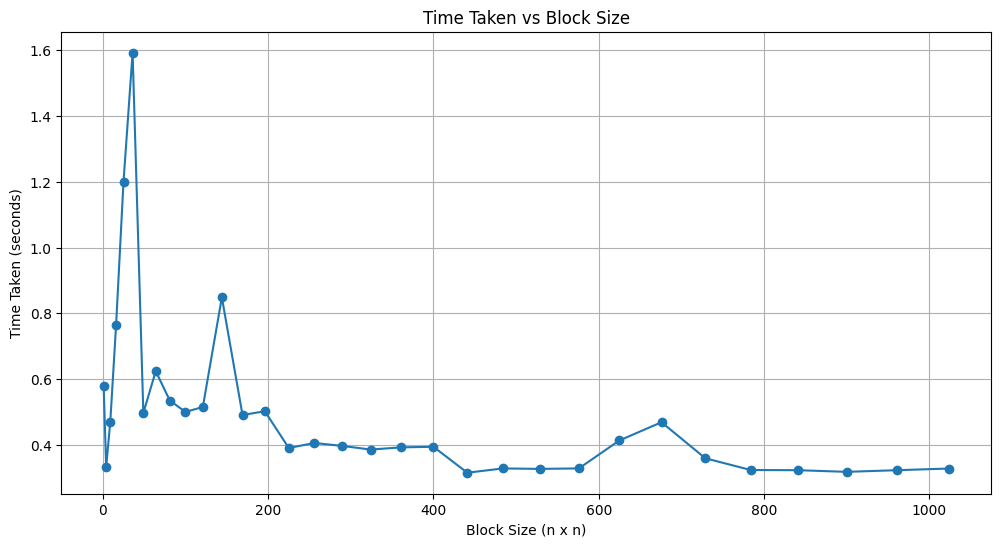

In [1]:
import matplotlib.pyplot as plt

# Block sizes and their corresponding time taken
block_sizes = [
    1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169,
    196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576,
    625, 676, 729, 784, 841, 900, 961, 1024
]
times = [
    0.5780644416809082, 0.3330867290496826, 0.4708402156829834, 0.7632973194122314,
    1.2003858089447021, 1.5920870304107666, 0.49735093116760254, 0.6243195533752441,
    0.5351412296295166, 0.500298023223877, 0.5156173706054688, 0.8485956192016602,
    0.49115848541259766, 0.502424955368042, 0.39086127281188965, 0.40602946281433105,
    0.39733099937438965, 0.38613390922546387, 0.3927173614501953, 0.39452457427978516,
    0.31567978858947754, 0.328716516494751, 0.3273491859436035, 0.3288075923919678,
    0.41376543045043945, 0.46909308433532715, 0.3595736026763916, 0.3238821029663086,
    0.32333898544311523, 0.31836748123168945, 0.323352575302124, 0.32842373847961426
]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(block_sizes, times, marker='o')
plt.title('Time Taken vs Block Size')
plt.xlabel('Block Size (n x n)')
plt.ylabel('Time Taken (seconds)')
plt.xscale('linear')  # You can change to 'log' if needed
plt.grid(True)

# Show the plot
plt.show()
